## CZ4042: Neural Networks and Deep Learning Group Project
Chua Yong Xuan, Daniel Yang, Jiang Zixing

## C. Sentiment Analysis in Text

Text Sentiment Analysis (TSA) plays a crucial role in understanding the underlying sentiments, be it positive or negative, expressed within texts or documents. The aim of this notebook is to explore and develop deep learning techniques for TSA in various scenarios:

1. **Domain Adaptation**: Investigate how a neural network trained on one domain can be adapted and applied to another domain.
2. **Comparative Analysis of Transformers**: Examine and compare the performance of different transformer architectures for sentiment analysis tasks.
3. **Handling Small Datasets**: Develop strategies to effectively deal with small datasets that have an insufficient number of training samples.


## Data Processing and Augmentation for Sentiment Analysis

In this notebook, we will be working with a financial news dataset consisting of sentiment and statement pairs, with statements related to financial news, along with their corresponding sentiments (positive, negative, and neutral).

The dataset is obtained from https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news/data.

The dataset we will use is stored in `all-data.csv`. Our first step is to preprocess the raw data by removing any duplicate entries, and to encode the sentiment labels to integers.

To test strategies to handle model training on small datasets, we want to generate more data points in our dataset to reduce the imbalance in the class labels. To do so, we will use:
1. Google Translate Augmentation
2. `nlpaug` Augmentation

Installing dependencies and importing necessary libraries

In [ ]:
# !pip install transformers
!pip install deep-translator
!pip install numpy requests nlpaug
!pip install transformers

import random
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
from tqdm import tqdm
from nlpaug.augmenter.word import SynonymAug
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.3 MB/s eta 0:00:00


In order to ensure reproducibility of our results, we are setting the random seeds for different libraries we are using in our notebook. This makes the random functions in these libraries generate the same values every time the notebook is run.

In [ ]:
# Seed Python random
random_seed = 42
random.seed(random_seed)

# Seed NumPy random
np.random.seed(random_seed)

# Seed PyTorch random
torch.manual_seed(random_seed)

# Seed the CUDA random number generator
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Set the cuDNN backend to be deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Reading the Dataset
In this section, we are loading and displaying our dataset, which is stored in a CSV file named `all-data.csv`.

In [ ]:
# Load the dataset from CSV file
df = pd.read_csv('all-data.csv', header=None, encoding='ISO-8859-1')

# Set column names for the dataframe
df.columns = ['sentiment', 'statement']

# Display the first 5 rows of the dataframe
df.head()

,sentiment,statement
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


### Removing Duplicates
We eliminate repeated instances of data points by dropping duplicates from our dataset as it helps to maintain data quality. From the code block, we note that there are 6 rows removed after dropping duplicate rows.

In [ ]:
# Count before dropping duplicates
count_before = len(df)
print(f"Number of rows before dropping duplicates: {count_before}")

# Drop duplicate rows
df = df.drop_duplicates()

# Count after dropping duplicates
count_after = len(df)
print(f"Number of rows after dropping duplicates: {count_after}")
print(f"Number of rows removed: {count_before - count_after}")

Number of rows before dropping duplicates: 4846
Number of rows after dropping duplicates: 4840
Number of rows removed: 6


### Dataset Distribution and Counts
After dropping duplicates, the dataset comprises a total of 4,840 data points. A closer look at the class distribution in the 'sentiment' column reveals an imbalance: there are 2,873 neutral samples, 1,363 positive samples, and 604 negative samples. This imbalance, coupled with the dataset's relatively small size, can pose challenges for the models, as they may become biased toward predicting the majority class (neutral in this case).

To mitigate these challenges and enhance model performance, we will employ upsampling methods to increase the counts of the minority classes (positive and negative) to match that of the majority class (neutral), thereby balancing the dataset. This approach will help create a more robust and unbiased model that performs well across all classes.

Total number of counts: 4840
Counts per class in the 'sentiment' column:
neutral     2873
positive    1363
negative     604
Name: sentiment, dtype: int64


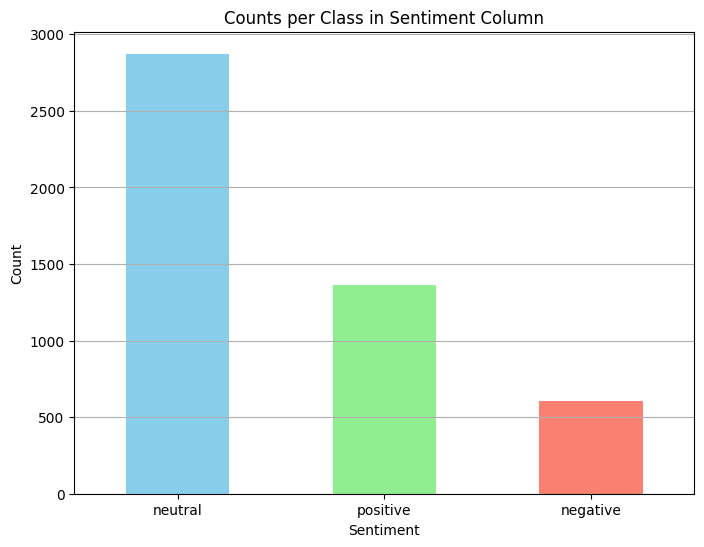

In [ ]:
# Total number of counts
total_counts = len(df)
print(f"Total number of counts: {total_counts}")

# Counts per class in the 'sentiment' column
class_counts = df['sentiment'].value_counts()
print("Counts per class in the 'sentiment' column:")
print(class_counts)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
class_counts.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'salmon'])
ax.set_title('Counts per Class in Sentiment Column')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.grid(axis='y')
plt.xticks(rotation='horizontal')

# Show the plot
plt.show()

### Label Encoding
We encode the sentiment labels in the 'sentiment' column of the DataFrame `df` from string values to numerical values. `positive` labels are mapped to `2`, `neutral` labels are mapped to `1`, `negative` labels are mapped to `0`.

In [ ]:
# Encode sentiment labels
df['sentiment'] = df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

df.head()

,sentiment,statement
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


## Splitting the Dataset
Before proceeding with the data augmentation methods, we split the dataset into train, validation, and test sets. We take 20% of the data for the test set, and use 20% of the remaining data as the validation set. The remaining data is used as the train set, and we will perform upsampling on the train set in a bid to improve our model performance.

In [ ]:
# Split the data into train, val, test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Show the shape of the resulting dataframes
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (3097, 2)
Validation set shape: (775, 2)
Test set shape: (968, 2)


### Exporting the Original Dataset
We export the train, validation, and test datasets for use in our model development and evaluation.

In [ ]:
train_df.to_csv('train.csv', index=False)
val_df.to_csv('validation.csv', index=False)
test_df.to_csv('test.csv', index=False)

### Upsampling the Original Dataset
Upon inspection, we notice that the dataset is both small and imbalanced, with `negative` (`0`) sentiment classes having significantly fewer samples than others. In fact, the dataset was selected to specifically tackle the challenge of developing strategies to effectively deal with small datasets in the context of domain adaptation. To address this issue, we will explore and implement various techniques to increase the count of samples in the `negative` (`0`) class:

1. **Google Translate Augmentation**:
   - We will use Google Translate to translate statements from English to French, and then back to English. This will generate additional samples that have the same meaning but differ in their text structure.

2. **nlpaug Augmentation**:
   - We will utilize the `nlpaug` library to create augmented samples of the unbalanced classes. This will be done by substituting words with their synonyms, thus generating new statements that retain the original meaning.

3. **GPT-2 Augmentation**:
   - We will utilize the `gpt2` library to expand on the given article titles with reasonable contextual text. This will generate new bodies of text containing the orginal article title and outputs reflective of GPT-2's processing.


### Using Google Translate Augmentation
We can artificially increase the size of the train dataset by translating text data into a different language and then back to the original language. This process generates new text samples that have the same meaning as the original text, but with possible variations in word choice and sentence structure due to the translation process.

In [ ]:
# Translate text from source language to target language
def translate_text(text, source_lang, target_lang):
    translator = GoogleTranslator(source=source_lang, target=target_lang)
    translated = translator.translate(text)
    return translated

# Translate a specific column in the DataFrame
def apply_translate(df, target_col, new_col, source_lang, target_lang):
    res = []
    # Iterate through each row in the DataFrame
    for i in tqdm(range(len(df))):
        txt = df.loc[i, target_col]
        # Translate the text and store the result
        res.append(translate_text(txt, source_lang=source_lang, target_lang=target_lang))
    # Store the translated text in new_col
    df[new_col] = res
    return df

We store the data points with negative sentiments in the `neg_df` DataFrame.

In [ ]:
# Create a new DataFrame that only consists of statements with negative sentiments
neg_df = train_df[train_df.sentiment == 0].reset_index(drop=True)
neg_df.shape

(396, 2)

In this code block, we are performing Google Translate augmentation to generate new text samples for the negative sentiment class in the dataset, stored in the `neg_df` DataFrame.

In [ ]:
# Creates a new column `fr` which translates the original statement to French
neg_df = apply_translate(neg_df, target_col='statement', new_col='fr', source_lang='en', target_lang='fr')

# Creates a new column `en` which translates the French statement back to English
neg_df = apply_translate(neg_df, target_col='fr', new_col='en', source_lang='fr', target_lang='en')

100%|██████████| 396/396 [01:28<00:00,  4.50it/s]


The `neg_df` DataFrame now consists of the generated translations in the `en` column.

In [ ]:
neg_df.head()

,sentiment,statement,fr,en
0,0,Nokia Siemens Networks has struggled to make a...,Nokia Siemens Networks a eu du mal à réaliser ...,Nokia Siemens Networks has struggled to turn a...
1,0,Dolce & Gabbana has asked the European Union t...,Dolce & Gabbana a demandé à l'Union européenne...,Dolce & Gabbana has asked the European Union t...
2,0,Performance in 2006 was impacted by the consol...,La performance en 2006 a été influencée par la...,Performance in 2006 was influenced by the cons...
3,0,"National Conciliator Juhani Salonius , who met...","Le conciliateur national Juhani Salonius, qui ...","National conciliator Juhani Salonius, who met ..."
4,0,Loss after financial items totalled EUR 9.7 mn...,La perte après éléments financiers s'élève à 9...,The loss after financial items amounted to 9.7...


We remove the duplicate rows after performing Google Translate augmentation, and store the translated rows into a new DataFrame `neg_df_new`.

In [ ]:
print(f"Number of rows in neg_df before dropping duplicates: {len(neg_df)}")

neg_df_new = neg_df[(neg_df['statement'].str.replace(' ', '')) != (neg_df['en'].str.replace(' ', ''))]

print(f"Number of rows in neg_df after dropping duplicates: {len(neg_df_new)}")
print(f"Number of rows removed from neg_df: {len(neg_df) - len(neg_df_new)}")

neg_df_new = neg_df_new.drop(columns=['statement', 'fr'])
neg_df_new.columns = ['sentiment', 'statement']

Number of rows in neg_df before dropping duplicates: 396
Number of rows in neg_df after dropping duplicates: 387
Number of rows removed from neg_df: 9


The new augmented data is now concatenated into the original dataset to produce the `translated_df` DataFrame. The dataset now consists of 1,194 samples with sentiment `0` (`negative`), increasing the proportion of the negative samples to be almost on par with class `2` (`positive`). We can now export this dataset augmented using Google Translate as `google-translate-train.csv`.

In [ ]:
translated_df = pd.concat([neg_df_new, train_df], axis=0).reset_index(drop=True)
translated_df.sentiment.value_counts()

1    1843
2     858
0     783
Name: sentiment, dtype: int64

In [ ]:
translated_df.to_csv('google-translate-train.csv', index=False)

### Using `nlpaug` Library
We can also perform text augmentation by using the `nlpaug` library by replacing words in the statements of our dataset with synonyms.

In [ ]:
def upsample_dataset(dataframe, target_column):
    # Identify the class distribution
    class_distribution = dataframe[target_column].value_counts()

    # Upsample minority class
    minority_class = class_distribution.idxmin()
    minority_class_size = class_distribution.min()

    class_label = minority_class
    class_data = dataframe[dataframe[target_column] == class_label]
    class_size = class_distribution[class_label]

    # Perform text augmentation
    aug = SynonymAug(aug_src='wordnet')
    augmented_texts = []
    show_example = True
    for text in class_data['statement']:
      augmented_texts.append(aug.augment(text)[0])
      if show_example:
        print("Example of augmented data:")
        print("Original text:", text)
        print("Augmented text:", augmented_texts[-1])
        show_example = False

    # Combine original, augmented data
    upsampled_data = pd.concat([dataframe, pd.DataFrame({target_column: class_label, 'statement': augmented_texts})])
    upsampled_data = upsampled_data.drop_duplicates()
    return upsampled_data

# Upsample dataset
upsampled_df = upsample_dataset(train_df, 'sentiment')

Example of augmented data:
Original text: Nokia Siemens Networks has struggled to make a profit in the past two years .
Augmented text: Nokia Siemens Networks get struggled to make a net income in the retiring two years.


The `upsampled_df` DataFrame now consists of more rows of the class `0` (`negative`) sentiments, compared to previously before the augmentation step.

In [ ]:
print(upsampled_df.sentiment.value_counts())
upsampled_df

1    1843
2     858
0     792
Name: sentiment, dtype: int64


,sentiment,statement
3874,1,The operations to be sold include manufacturin...
1855,1,L&T has also made a commitment to redeem the r...
1629,1,The deal was worth about EUR 1.2 mn .
2453,1,FinancialWire tm is not a press release servic...
1422,1,The share of the share capital of both above m...
...,...,...
391,0,"Outokumpu ' s steel john mill in Tornio, in Fi..."
392,0,The net sales lessen to EUR 49. 8 million from...
393,0,Finnish electronics contract manufacturer Scan...
394,0,Finnish IT solutions provider Affecto Oyj hela...


We export the dataset upsampled using the `nlpaug` library as `nlpaug-train.csv` for use in our model development.

In [ ]:
upsampled_df.to_csv('nlpaug-train.csv', index=False)

### `GPT-2` Augmentation
We import the training dataset augmented with the `gpt-2` library to generate more flavourful text for training.

The GPT-2 library, developed by OpenAI, functions as a decoder that excels at predicting the next set of tokens in a sequence. This ability enables GPT-2 to generate text that is syntactically coherent when provided with a series of tokens, lengthening/modifying our training set.

In [ ]:
sample_size = 10
qa_train_pairs = train_df.sample(n = sample_size)
decoding_labels = {2: 'positive', 1: 'neutral', 0: 'negative'}

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

text = ''
for index, qa in qa_train_pairs.iterrows():
  sentiment = decoding_labels[qa['sentiment']]
  text += f"Q: {qa['statement']}? A: {sentiment} {tokenizer.eos_token}"
print(text)

input_ids = tokenizer.encode(text, add_special_tokens=True, return_tensors='pt')

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(15):
  optimizer.zero_grad()
  loss = model(input_ids.to(device), labels=input_ids.to(device))[0]
  loss.backward()
  optimizer.step()
  scheduler.step()
  if epoch % 100 == 0:
    print(f"Epoch {epoch}, Loss {loss.item()}")

# model.eval()

Q: Applying for summer work is seen as laborious and stressful .? A: negative <|endoftext|>Q: The company expects meat purchases to remain at about 8mn kilos in 2011 .? A: neutral <|endoftext|>Q: The ship cranes , which will be manufactured by MacGREGOR 's partner plants in China , will be delivered between 2008-2010 for vessels ordered by Chinese COSCO , German Peter Dohle and Hong Kong based Cido Shipping .? A: neutral <|endoftext|>Q: The initial estimated total value was 1744900 EUR and the final award value was 1744900 EUR .? A: neutral <|endoftext|>Q: Neomarkka has played a leading role in a group that aims to restart the production of specialty cellulose fiber in Valkeakoski .? A: neutral <|endoftext|>Q: Via the agreement , Ramirent will expand the range of equipment and services it delivers to Destia , Ramirent Finland 's managing director Kari Aulasmaa , said .? A: positive <|endoftext|>Q: Nokia was up 0.12 pct to 16.70 eur after kicking off the morning in negative territory .?

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0, Loss 4.864789962768555


In [ ]:
answers = []

# Use tqdm to create a progress bar for the iteration
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Generating Answers"):
    input_ids = tokenizer.encode(row['statement'] + " Given this article headline, what is the sentiment?", add_special_tokens=False, return_tensors='pt').to(device)

    # Generate the answer using the model
    output = model.generate(input_ids, do_sample=True, max_length=300, top_k=20, top_p=1.0)

    # Decode the generated answer using the tokenizer
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    answers.append(answer)

Streaming output truncated to the last 5000 lines.
Generating Answers:  19%|█▉        | 598/3097 [07:55<39:14,  1.06it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Generating Answers:  19%|█▉        | 599/3097 [07:56<32:48,  1.27it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Generating Answers:  19%|█▉        | 600/3097 [07:56<25:25,  1.64it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-en

We export the dataset augmented using the GPT-2 as `gpt-augment-train.csv` for use in our model development.

In [ ]:
train_df['gpt_output'] = answers
train_df.to_csv('gpt-augment-train.csv', index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>